# Estimating Annual Radiation Intensities on Buildings using Neurel Network

In [1]:
import sys, os, glob
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_colwidth', -1)

## Pre-Processing

- Get the file names of simulation results

In [2]:
# you can later use this array to iterate through all files
filepath = 'result' # replace this with the path in your drive to the cs109_ folder results_sample folder on the drive
files = [file for file in glob.glob(filepath+"/*.txt")]
print ("NUMBER OF FILES IN RESULT FOLDER: ", len(files))

NUMBER OF FILES IN RESULT FOLDER:  1526


##### Functions

In [3]:
def getBuildingHeights(filename):
    '''
    input: name of result file
    output: array of 3 heights of our target building (i.e [3,27,6])
    '''
    return filename.split("/")[-1].replace(".txt", "").split(",")

def createColumnMapper():
    mapper = {0: "x", 1:"y", 2:"z"}
    month = [calendar.month_name[i+1] for i in range(12)]
    for i in range(3, 3+12):
        mapper[i] = month[i-3]
    return mapper

def convertToDF(fname):
    '''
    input: name of result file
    output: pandas df
    '''
    with open(fname) as f:
        content = f.readlines()   
    content = np.array([line.replace("\n", "").split(",") for line in content[1:]])
    return pd.DataFrame(data=content)

def matplotlibViz(df, angle1=None, angle2=None, s=1, z=None):
    '''
    Visualizes in 3D a dataframe
    input: dataframe
    output: None
    '''
    color = {0: 'blue', 1:'red'}
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    df = df.loc[(df['building'] == 1) & (df['z'] == z)] if z != None else df.loc[df['building'] == 1]
    df['moved'] = df['moved'].apply(lambda x: color[int(x)])
    ax.scatter(df['x'], df['y'], df['z'], s=s, color=df['moved'])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.view_init(angle1, angle2)
    plt.title("3-D rendered building")
    plt.show()
    
def convertToGridWithoutPad(df, size=(100,100,100), increment=1):
    '''
    zero pad all the coordinates that do not have radiation values (even the coordinates inside the building are zero padded).
    input: dataframe
    output: dataframe
    
    '''
    res = []
    temp = df[['x', 'y', 'z']]*2
    # NEW RESULT WITH RAD VALUE (CHANGES START HERE)
    temp['rad'] = df_building[['Annual Sum']]
    temp = temp.apply(pd.to_numeric, errors='coerce', downcast="integer")
    # CREATE HASHMAP FOR RADIATION
    hashmap = {}
    for index, row in temp.iterrows():
        hashmap[tuple(row[:-1])] = row[-1]
    
    for z in range(0, size[0]+increment, increment):
        for y in range(0, size[0]+increment, increment):
            for x in range(0, size[0]+increment, increment):
                if (x,y,z) in hashmap:
                    res.append([x,y,z,hashmap[(x,y,z)], 1, 1]) # FOURTH COLUMN WE ADD RADIATION
                else:
                    res.append([x,y,z,0,0, 1]) # FOURTH COLUMN WE ADD RADIATION, BUT ITS ALL ZERO BECAUSE IT'S INSIDE THE BUILDING
    
    return pd.DataFrame(data=res, columns=['x', 'y', 'z', 'rad', 'building', 'moved'])            
                    
    
def convertToGrid(df, size=(100,100,100), increment=1):
    '''
    zero pad all the coordinates that do not have radiation values (even the coordinates inside the building are zero padded).
    input: dataframe
    output: dataframe
    
    '''
    res = []
    marked = set()
    
    temp = df[['x', 'y', 'z']]*2
    temp['rad'] = df[['Annual Sum']]
    temp = temp.apply(pd.to_numeric, errors='coerce', downcast="integer")
    # CREATE HASHMAP FOR RADIATION
    hashmap = {}
    for index, row in temp.iterrows():
        hashmap[tuple(row[:-1])] = row[-1]
    
    temp = False
    for z in range(0, size[0]+increment, increment):
        for y in range(0, size[0]+increment, increment):
            for x in range(0, size[0]+increment, increment):
                if (x,y,z) in hashmap:
                    if temp:
                        res.append([x,y,z,hashmap[(x,y,z)], temp])
                        temp = not temp
                    else:
                        temp = not temp
                        res.append([x,y,z,hashmap[(x,y,z)], temp])
                else:
                    res.append([x,y,z,0,temp]) 
    
    return pd.DataFrame(data=res, columns=['x', 'y', 'z', 'rad', 'building'])

In [4]:
def matplotlibViz(df, angle1=None, angle2=None, s=1, z=None):
    '''
    Visualizes in 3D a dataframe
    input: dataframe
    output: None
    '''
    color = {0: 'blue', 1:'red', 2:'green', 3: 'black'}
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    df = df.loc[(df['building'] == 1) & (df['z'] == z)] if z != None else df.loc[df['building'] == 1]
    df['moved'] = df['moved'].apply(lambda x: color[int(x)])
    ax.scatter(df['x'], df['y'], df['z'], s=s, color=df['moved'])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.view_init(angle1, angle2)
    plt.title("3-D rendered building")
    plt.show()

def pushSurfacesInside(df, size=(100,100,100), increment=1):
    res = []
    temp = df[['x', 'y', 'z']]*2
    temp['rad'] = df[['Annual Sum']]
    temp = temp.apply(pd.to_numeric, errors='coerce', downcast="integer")
    # CREATE HASHMAP FOR RADIATION
    radiationMap = {}
    for index, row in temp.iterrows():
        radiationMap[tuple(row[:-1])] = row[-1]
    
    # X - Axis PUSH INSIDE
    for z in range(0, size[0]+increment, increment):
        for y in range(0, size[0]+increment, increment):
            for x in range(0, size[0]+increment, increment):
                if (x,y,z) in radiationMap and (x+increment*2, y, z) not in radiationMap:
                    res.append([x+1,y,z, radiationMap[(x,y,z)], 1, 1])
                    break
                elif (x,y,z) in radiationMap and (x+increment*2, y, z) in radiationMap:
                    break
            for x in reversed(range(0, size[0]+increment, increment)):
                if (x,y,z) in radiationMap and (x-increment*2, y, z) not in radiationMap:
                    res.append([x-1,y,z, radiationMap[(x,y,z)], 1, 2])
                    break
                elif (x,y,z) in radiationMap and (x-increment*2, y, z) in radiationMap:
                    break
    
    # Y - Axis PUSH INSIDE
    for z in range(0, size[0]+increment, increment):
        for x in range(0, size[0]+increment, increment):
            for y in range(0, size[0]+increment, increment):
                if (x,y,z) in radiationMap and (x, y+increment*2, z) not in radiationMap:
                    res.append([x,y+1,z, radiationMap[(x,y,z)], 1, 1])
                    break
                elif (x,y,z) in radiationMap and (x, y+increment*2, z) in radiationMap:
                    break
            for y in reversed(range(0, size[0]+increment, increment)):
                if (x,y,z) in radiationMap and (x, y-increment*2, z) not in radiationMap:
                    res.append([x,y-1,z, radiationMap[(x,y,z)], 1, 2])
                    break
                elif (x,y,z) in radiationMap and (x, y-increment*2, z) in radiationMap:
                    break
    
    # Z - Axis PUSH INSIDE
    for x in range(0, size[0]+increment, increment):
        for y in range(0, size[0]+increment, increment):
            for z in range(0, size[0]+increment, increment):
                if (x,y,z) in radiationMap and (x, y, z+increment*2) not in radiationMap:
                    res.append([x,y,z+1, radiationMap[(x,y,z)], 1, 0])
                    break
                elif (x,y,z) in radiationMap and (x, y, z+increment*2) in radiationMap:
                    break
            for z in reversed(range(0, size[0]+increment, increment)):
                if (x,y,z) in radiationMap and (x, y, z-increment*2) not in radiationMap:
                    res.append([x,y,z-1, radiationMap[(x,y,z)], 1, 0])
                    break
                elif (x,y,z) in radiationMap and (x, y, z-increment*2) in radiationMap:
                    break
                    
    return pd.DataFrame(data=res, columns=['x', 'y', 'z', 'Annual Sum', 'building', 'moved'])  

In [5]:
import collections

def removeOverlappingPoints(df):
    '''
    REMOVES OVERLAPPING COORDINATES THAT HAVE MORE THAN ONE VALUE
    
    '''
    everyDataPointIncludingOverlaps =  [tuple(row[:3]) for idx, row in df.iterrows()]
    hashmap = {tuple(row[:3]): row[3] for index, row in df.iterrows()}  # CREATE HASHMAP FOR RADIATION
    counter = collections.Counter(everyDataPointIncludingOverlaps)
    uniqueCoordinates = [k for k, v in counter.items() if v == 1]  
#     print ('NUMBER OF UNIQUE COORDINATES' , len(uniqueCoordinates))
    res = [list(row) for idx, row in df.iterrows() if tuple(row[:3]) in uniqueCoordinates]   
    return pd.DataFrame(data=res, columns=['x', 'y', 'z', 'Annual Sum', 'building', 'moved']) 


In [6]:
def convertToGrid(df, size=(100,100,100), increment=1):
    '''
    zero pad all the coordinates that do not have radiation values (even the coordinates inside the building are zero padded).
    input: dataframe
    output: dataframe
    
    '''
    res = []
    # CREATE HASHMAP FOR RADIATION
    hashmap = {}
    for index, row in df.iterrows():
        hashmap[tuple(row[:3])] = row[4:]
    
    for z in range(0, size[0]+increment, increment):
        for y in range(0, size[0]+increment, increment):
            padding = False
            for x in range(0, size[0]+increment, increment):
                if (x,y,z) in hashmap and (x+increment*2, y, z) not in hashmap:
                    x += increment*2
                    while ((x,y,z) not in hashmap):
                        res.append([x,y,z, 0, 1, 3])
                        x += increment*2
                    break
                elif (x,y,z) in hashmap and (x+increment*2, y, z) in hashmap:
                    break
    original = [list(row) for index, row in df.iterrows()]
    return pd.DataFrame(data=res+original, columns=['x', 'y', 'z', 'rad', 'building', 'moved'])

In [7]:
def format_X_y(final):  
    X_mat_formatted = np.zeros((50,50,50,1))
    y_mat_formatted = np.zeros((50,50,50,1))

    input_df = final[['x', 'y', 'z','rad']]
    for row in input_df.itertuples():
        idx_x = int((row.x/2)-0.5)
        idx_y = int((row.y/2)-0.5)
        idx_z = int((row.z/2)-0.5)

        X_mat_formatted[idx_x, idx_y,idx_z,0] = 1
        y_mat_formatted[idx_x, idx_y,idx_z,0] = row.rad

    return X_mat_formatted, y_mat_formatted


In [8]:
def txt2matrix(filename):
    df = convertToDF(filename)
    if df.shape[1] > 4:
        df_building = df.rename(index=int, columns=createColumnMapper()).rename(index=int, columns={15:"Annual Sum"}).apply(pd.to_numeric, errors='coerce')
    else:
        df_building = df.rename(index=int, columns={0:'x',1:'y',2:'z',3:'Annual Sum'})
    df_building_pushed = pushSurfacesInside(df_building)
    df_building_pushed_overlap_removed = removeOverlappingPoints(df_building_pushed)
    final = convertToGrid(df_building_pushed_overlap_removed)
    return format_X_y(final)

- Process the data

In [9]:
boundary, _ = txt2matrix('point_boundary.txt')

In [41]:
f

'result/0,15,6.txt'

In [42]:
i

1282

In [43]:
X = []
Y = []
for i, f in enumerate(files):
    if i in [106, 182, 744, 1090, 1190, 1282]: # Some issue with (0,0,6),(22,0,14),(12,27,6)
        continue
    print('Processing '+str(i)+'/'+str(len(files))+' file',end='\r')
    npy_f_x = f.replace('.txt','_x.npy').replace('/','_npy/')
    npy_f_y = f.replace('.txt','_y.npy').replace('/','_npy/')
    if len(glob.glob(npy_f_x))==0 or len(glob.glob(npy_f_y))==0:
        x, y = txt2matrix(f)
        x += boundary
        np.save(npy_f_x,x)
        np.save(npy_f_y,y)
    else:
        x = np.load(npy_f_x)
        y = np.load(npy_f_y)
    X.append(x)
    Y.append(y)
    
X = np.array(X)
Y = np.array(Y)

print (X.shape, Y.shape)

(1520, 50, 50, 50, 1) (1520, 50, 50, 50, 1)


In [55]:
Y.max()

1434.4

In [56]:
y_max = 1500
Y /= y_max

In [44]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, X_test.shape)

(1216, 50, 50, 50, 1) (304, 50, 50, 50, 1)


## Model

In [46]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Permute
from keras.layers import Conv3D, Deconvolution3D, MaxPooling3D, UpSampling3D, ZeroPadding3D

Using TensorFlow backend.


#### Loss Function

In [47]:
def RadiationLoss(y_true, y_pred):
    """
    Compute the loss for the radiation matrix.
    
    Inputs:
    - y_true: radiation of the target building. 3D Tensor with radiation value at taget surface and others 0.
    - y_pred: the prediction of the radiation.
    
    Returns:
    - scalar mse loss, only calculated where radiation value not equal to zero
    """
    
    y_loc = K.cast(K.not_equal(y_true,K.constant(0)),'float')
    return K.sum(K.pow(y_true-y_pred*y_loc,2))/K.sum(y_loc)
    

In [58]:
matrix_size = (50, 50, 50, 1)

inp = Input(matrix_size)

# Voxnet structure + autoencoder
enc = Conv3D(32, kernel_size=5, strides=2, padding='same', activation='relu')(inp)
enc = Conv3D(32, kernel_size=3, strides=1, padding='same', activation='relu')(enc)
enc = MaxPooling3D((2,2,2))(enc)

enc = Conv3D(64, kernel_size=5, strides=2, padding='same', activation='relu')(enc)
enc = Conv3D(64, kernel_size=3, strides=1, padding='same', activation='relu')(enc)
enc = MaxPooling3D((2,2,2))(enc)
conv_shape = enc.get_shape().as_list()

enc = Flatten()(enc)
latent = Dense(256, activation='relu')(enc)

dec = Dense(np.prod(conv_shape[1:]), activation='relu')(latent)
dec = Reshape(conv_shape[1:])(dec)

dec = UpSampling3D((2,2,2))(dec)
dec = Deconvolution3D(64, kernel_size=3, strides=1, padding='same', activation='relu')(dec)
dec = Deconvolution3D(64, kernel_size=5, strides=2, padding='same', activation='relu')(dec)

dec = UpSampling3D((2,2,2))(dec)
dec = ZeroPadding3D(((0,1),(0,1),(0,1)))(dec) # pad 0s at one side to match the size
dec = Deconvolution3D(32, kernel_size=3, strides=1, padding='same', activation='relu')(dec)
dec = Deconvolution3D(32, kernel_size=5, strides=2, padding='same', activation='relu')(dec)

out = Conv3D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(dec) # Assume normalized data [0,1]

voxnet_model = Model(inp, out)
voxnet_model.compile(optimizer='adam',loss=RadiationLoss)

In [59]:
voxnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 50, 1)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 25, 25, 25, 32)    4032      
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 25, 25, 25, 32)    27680     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 12, 12, 12, 32)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 6, 6, 6, 64)       256064    
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 6, 6, 6, 64)       110656    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 3, 3, 64)       0         
__________

In [60]:
history = voxnet_model.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

Train on 1216 samples, validate on 304 samples
Epoch 1/5
1216/1216 [==============================] - 70s 57ms/step - loss: 0.0275 - val_loss: 0.0118
Epoch 2/5
1216/1216 [==============================] - 69s 57ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 3/5
1216/1216 [==============================] - 70s 57ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 4/5
1216/1216 [==============================] - 70s 58ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/5
1216/1216 [==============================] - 70s 57ms/step - loss: 0.0026 - val_loss: 0.0020


In [75]:
Y_plt.shape

(125000,)

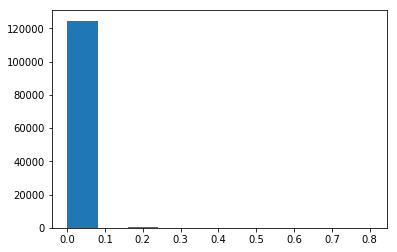

In [77]:
_=plt.hist(Y_plt)

In [87]:
def pltRadiationDistribution(y_true, y_pred, ax=None):
    y_true = y_true.reshape((-1,))
    y_pred = y_pred.reshape((-1,))
    y_pred = y_pred[y_true!=0]
    y_true = y_true[y_true!=0]
    plt_idx = np.argsort(y_true)
    if ax is None:
        plt.scatter(range(len(plt_idx)), y_true[plt_idx])
        plt.scatter(range(len(plt_idx)), y_pred[plt_idx])
        plt.xlabel('voxel index')
        plt.ylabel('radiation (normalize)')
        _=plt.legend(['truth','predict'])
    else:
        ax.scatter(range(len(plt_idx)), y_true[plt_idx])
        ax.scatter(range(len(plt_idx)), y_pred[plt_idx])
        ax.set_xlabel('voxel index')
        ax.set_ylabel('radiation (normalize)')
        ax.legend(['truth','predict'])


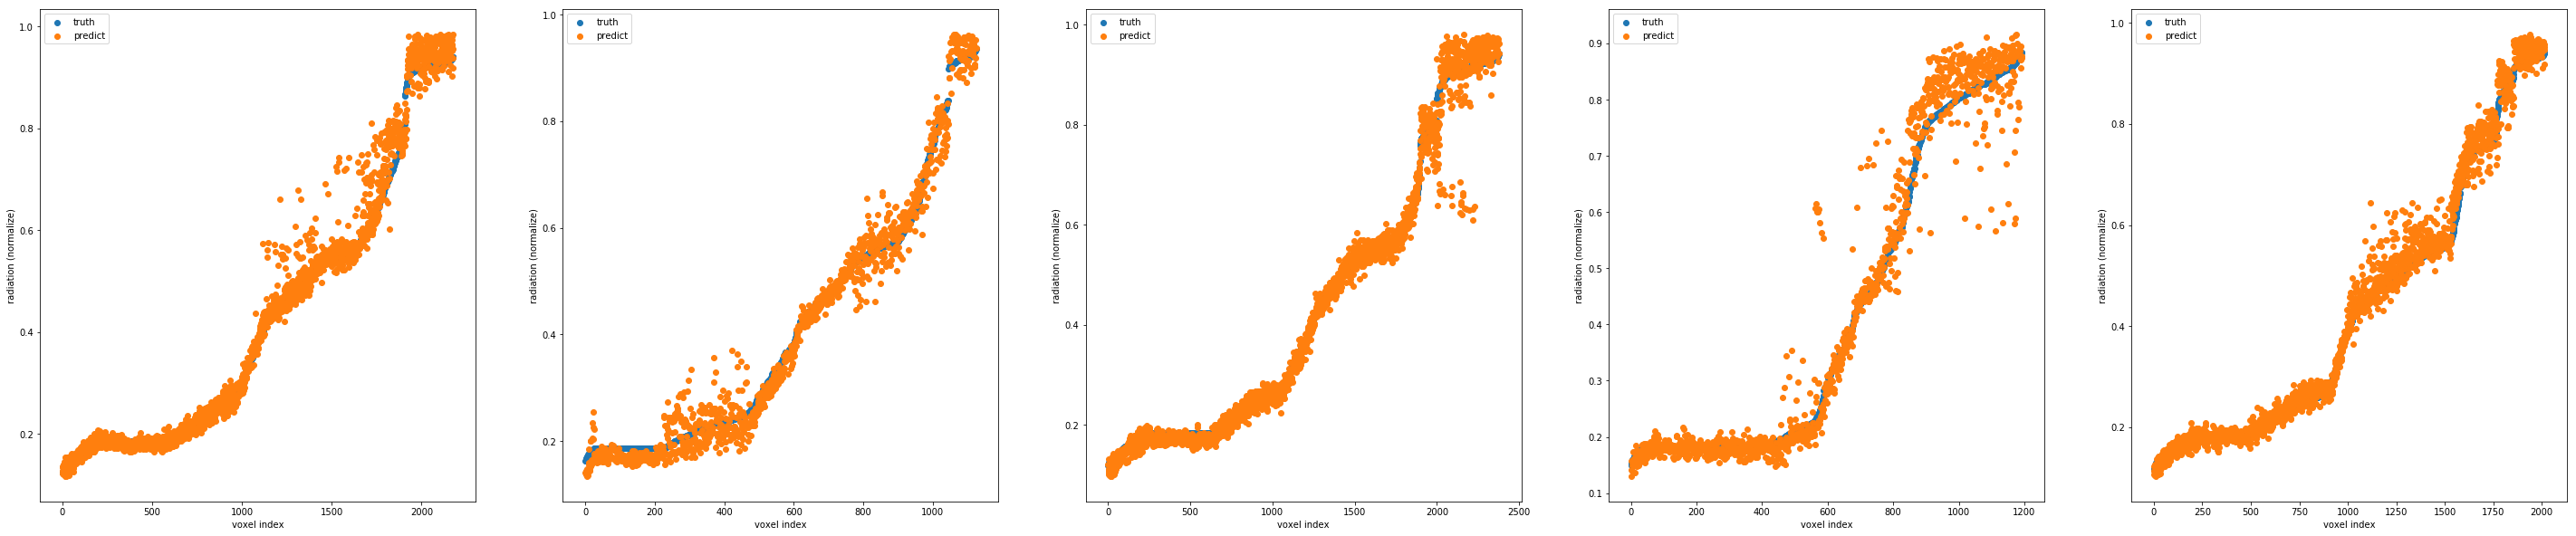

In [88]:
fig, axes = plt.subplots(1,5, figsize=(50,10))
for i in range(5):
    idx = np.random.randint(len(Y_test))
    pltRadiationDistribution(Y_test[idx], voxnet_model.predict(np.expand_dims(X_test[idx],axis=0))[0],ax=axes[i])